## Torch implementation of VAE

> VAE stands for Variational Autoencoders


Follow Readme.md for installation

## Load library

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F

from algorithms.vae_model import VAE

from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms, utils

## Load data and split into train and test set

In [2]:
class ChrimasDataset(Dataset):
    def __init__(self, files_path, transform=None) -> None:
        super(ChrimasDataset, self).__init__()
        self.files_path = np.array(files_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.files_path)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_path = self.files_path[index]
        image = io.imread(image_path)

        if self.transform:
            image = self.transform(image)
        
        return image

In [3]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        # image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return img # {'image': img}

In [4]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        # image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        img = image[top: top + new_h,
                      left: left + new_w]

        return img # {'image': image}

In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        img = image/255 # .transpose((2, 0, 1))
        return torch.from_numpy(img).float() # {'image': torch.from_numpy(image)}

In [6]:
import glob

images_path = glob.glob("../dataset/chrismas/*.jpg")
print(len(images_path))
print(images_path[0])

1877
../dataset/chrismas/image82.jpg


In [7]:
chrismas_dataset = ChrimasDataset(
    images_path, transforms.Compose([
        Rescale(124),
        RandomCrop(100),
        ToTensor()
    ])
)

Let visualize another example

In [8]:
print(len(chrismas_dataset))

image = next(iter(chrismas_dataset))
print(image.size())

1877
torch.Size([100, 100, 3])


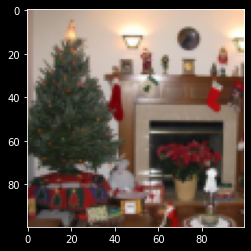

In [9]:
plt.imshow(image.numpy()*255)
plt.show()

In [10]:
train_size = int(0.8 * len(chrismas_dataset))
test_size = len(chrismas_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(chrismas_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

len(train_loader), len(test_loader)

(93, 376)

In [11]:
if torch.cuda.is_available():
    print('You use GPU !')
    device = torch.device('cuda')
else:
    print('You use CPU !')
    device = torch.device('cpu')

You use GPU !


In [12]:
in_dim = 100*100*3
batch_size = 16
max_epoch = 50
lr = 0.0005
weight_decay = 0.00075

encoder_hidden_layers = [512, 256, 128]
decoder_hidden_layers = [128, 256, 512]

latent_dim = 64

In [13]:
model = VAE(
    train_dataset,
    test_dataset,
    in_dim,
    encoder_hidden_layers,
    decoder_hidden_layers,
    latent_dim,
    device
)

## Train

In [14]:
# train VAE
hist_loss = model.train(batch_size, 10, lr, weight_decay)

100%|██████████| 10/10 [05:21<00:00, 32.17s/it, val_loss=314, epoch=9]


## A look at encoder/decoder architecture

![](https://miro.medium.com/max/1400/1*Q5dogodt3wzKKktE0v3dMQ@2x.png)

In [15]:
print(model.encoder)

Encoder(
  (base_model): Sequential(
    (0): Linear(in_features=30000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (latent_mean): Linear(in_features=128, out_features=64, bias=True)
  (latent_std): Linear(in_features=128, out_features=64, bias=True)
)


In [16]:
print(model.decoder)

Decoder(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=30000, bias=True)
  )
)


Save loss history

In [17]:
np.savetxt('./dataset/loss.csv', hist_loss, delimiter=',')

## Generate new data

Let generate an example

In [18]:
X_generated = model.generate_from_latent_space(1)

In [19]:
X_generated[0].size() # generated image is a size of input image

torch.Size([100, 100, 3])

Visualize generated with matplotly

Seem like 7 -:)

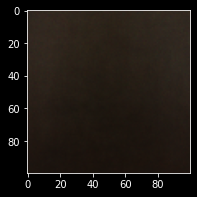

In [22]:
image = (X_generated[0]*255).cpu().detach().numpy()
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

Let generate 50 examples

In [26]:
X_generated = model.generate_from_latent_space(50) # generer 50 images

Random visualize 16 of these

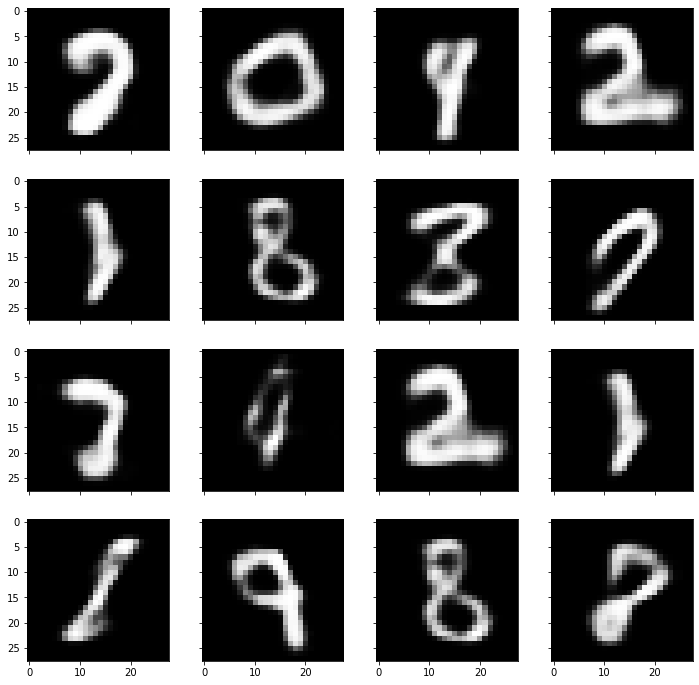

In [29]:
image_index = np.random.choice(50, 16)

fig, axis = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(12, 12))
selected_images = X_generated[image_index].cpu().detach().numpy()
for i in range(4):
    for j in range(4):
        image = selected_images[i*4+j]
        axis[i, j].imshow(image, cmap='gray')
plt.show()

Let generate image from example

In [30]:
data_input, X_generated = model.generate_from_test_data(2) # generer 2 images

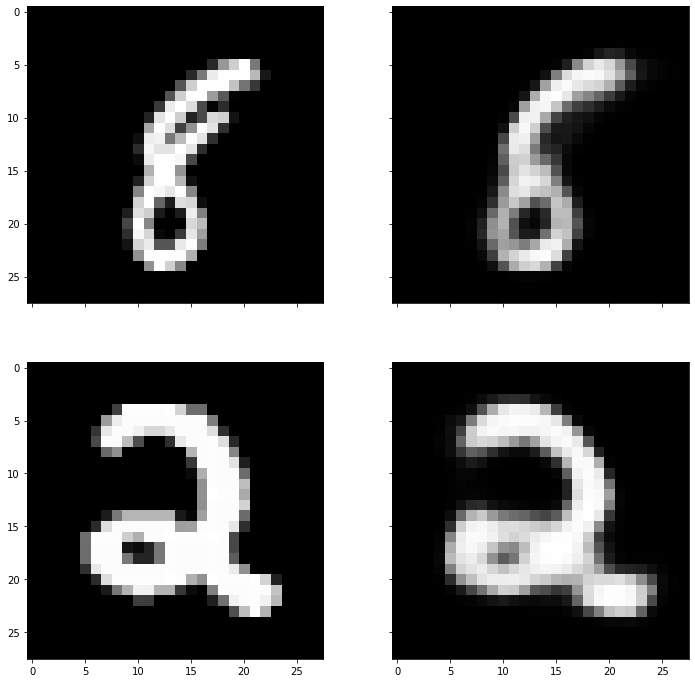

In [31]:
fig, axis = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 12))

image = data_input[0].cpu().detach().numpy()
axis[0, 0].imshow(image, cmap='gray')

image = X_generated[0].cpu().detach().numpy()
axis[0, 1].imshow(image, cmap='gray')

image = data_input[1].cpu().detach().numpy()
axis[1, 0].imshow(image, cmap='gray')

image = X_generated[1].cpu().detach().numpy()
axis[1, 1].imshow(image, cmap='gray')

plt.show()

Forked Source Code [here](https://github.com/shib0li/VAE-torch)